In [1]:
from abc import ABC, abstractmethod


In [2]:
from torch.utils.data import Dataset, DataLoader
from typing import List

In [3]:
from utils.validation import get_validation_recalls


In [4]:
import torchvision.transforms as T

In [5]:
import torch

In [6]:
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from models import helper
import numpy as np
from PIL import Image

In [75]:
class VPRModel(ABC):
    ''' Base interface to use models in auto-test framework '''
    def __init__(self):
        self.model = None
        self.device = 'cpu'
        
    @abstractmethod
    def input_transform(self) -> T.Compose:
        ''' Input image transform method'''
        pass

    @abstractmethod
    def get_embedding(self,img: Image) -> List[float]:
        ''' Method to geting embedding of a single image'''
        pass

    @abstractmethod
    def get_embeddings(self,imgs:List[Image]) -> List[List[float]]:
        ''' Method to geting embeddings of image list'''
        pass
        
    @abstractmethod
    def get_descriptors(self,val_loader: DataLoader) -> torch.Tensor:
        ''' A method for obtaining image embeddings for model testing on datasets'''
        pass
        
    def load_model_state_dict(self,path_to_weight: str):
        state_dict = torch.load(path_to_weight) 

        self.model.load_state_dict(state_dict)
        self.model.eval()
        
    def set_model_device(self,device:str):
        self.device = device
        self.model = self.model.to(self.device)

    

In [8]:
class BOQ(pl.LightningModule):
        def __init__(self,
                    #---- Backbone
                    backbone_arch='resnet50',
                    pretrained=True,
                    layers_to_freeze=1,
                    layers_to_crop=[],
                    normalize = True,
                     
                    #---- Aggregator
                    agg_arch='ConvAP', #CosPlace, NetVLAD, GeM, AVG
                    agg_config={},
                    
                     ):
            super().__init__()
            
            self.encoder_arch = backbone_arch
            self.pretrained = pretrained
            self.layers_to_freeze = layers_to_freeze
            self.layers_to_crop = layers_to_crop
            self.agg_arch = agg_arch
            self.agg_config = agg_config
            
            self.save_hyperparameters() # write hyperparams into a file
    
            
            # ----------------------------------
            # get the backbone and the aggregator
            self.backbone = helper.get_backbone(backbone_arch, pretrained, layers_to_freeze, layers_to_crop, normalize)
            self.aggregator = helper.get_aggregator(agg_arch, agg_config)
            
        # the forward pass of the lightning model
        def forward(self, x):
            x = self.backbone(x)
            x = self.aggregator(x)
            return x

In [60]:
class BOQVPR(VPRModel):

    
    


    def __init__(self,
                #---- Backbone
                backbone_arch='resnet50',
                pretrained=True,
                layers_to_freeze=1,
                layers_to_crop=[],
                normalize = True,
                 
                #---- Aggregator
                agg_arch='ConvAP', #CosPlace, NetVLAD, GeM, AVG
                agg_config={}
                
                
                 ):
        self.device = 'cpu'
        self.image_interpolation = T.InterpolationMode.BICUBIC
        self.input_transform_mean = [0.485, 0.456, 0.406] 
        self.input_transform_std = [0.229, 0.224, 0.225]
        if 'resnet' in backbone_arch:
            self.image_size = (320, 320)
        elif 'dino' in backbone_arch:
            self.image_size = (322, 322)
        else:
            self.image_size = (320, 320)

        self.model =  BOQ(backbone_arch = backbone_arch,pretrained = pretrained,
                          layers_to_freeze = layers_to_freeze, layers_to_crop = layers_to_crop,
                          normalize = normalize, agg_arch = agg_arch, agg_config = agg_config)  
    def input_transform(self):
        return T.Compose([
             T.Resize(self.image_size, interpolation=self.image_interpolation),
    		#T.Resize(image_size,  interpolation=T.InterpolationMode.BILINEAR),
            
            T.ToTensor(),
            T.Normalize(mean=self.input_transform_mean, std=self.input_transform_std)
        ])
    def get_descriptors(self,dataloader: DataLoader) -> torch.Tensor:
        descriptors = []
        with torch.no_grad():
            for batch in tqdm(dataloader, 'Calculating descritptors...'):
                imgs, labels = batch
                output= self.model(imgs.to(self.device))[0].cpu()
                descriptors.append(output)
    
        return torch.cat(descriptors)
        
    def get_embeddings(self, imgs: List[Image]):
        descriptors = []
        with torch.no_grad():
            for img in tqdm(imgs, 'Calculating descritptors...'):
                descriptors.append(self.get_embedding(img))
    
        return descriptors
    def get_embedding(self, img: Image) -> List[float]:
        img = self.input_transform()(img)[np.newaxis,:]
        with torch.no_grad():
            return self.model(img.to(self.device))[0].cpu().tolist()[0]

In [61]:
mm = BOQVPR(backbone_arch='dino', 
            normalize = True,
            agg_arch='boq',
            agg_config={
                'in_channels': 768,  # make sure the backbone has out_channels attribute
                'proj_channels': 384,
                'num_queries': 64,
                'num_layers': 2,
                'row_dim': 12288//384,
            })


Using cache found in /home/sunveil/.cache/torch/hub/facebookresearch_dinov2_main


In [62]:
mm.load_model_state_dict('/media/sunveil/Data/header_detection/poddubnyy/postgraduate/VPR/Bag-of-Queries/dinov2_12288.pth')

/tmp/ipykernel_432432/776511002.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_weight) # link to the trained weights


In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [64]:
mm.set_model_device(device)

In [76]:
mm?

Type:            BOQVPR
String form:     <__main__.BOQVPR object at 0x7f53ba52eff0>
Docstring:       <no docstring>
Class docstring:
Helper class that provides a standard way to create an ABC using
inheritance.

In [65]:
from dataloaders.val.EssexDataset import EssexDataset

In [66]:
def get_val_dataset(dataset_name, input_transform=mm.input_transform()):
    dataset_name = dataset_name.lower()
    
    if 'cross' in dataset_name:
        ds = CrossSeasonDataset(input_transform = input_transform)
    
    elif 'essex' in dataset_name:
        ds = EssexDataset(input_transform = input_transform)
    
    elif 'inria' in dataset_name:    
        ds = InriaDataset(input_transform = input_transform)
    
    elif 'nordland' in dataset_name:    
        ds = NordlandDataset(input_transform = input_transform)
    
    elif 'sped' in dataset_name:
        ds = SPEDDataset(input_transform = input_transform)
    
    elif 'msls' in dataset_name:
        ds = MSLS(input_transform = input_transform)

    elif 'pitts' in dataset_name:
        ds = PittsburghDataset(which_ds=dataset_name, input_transform = input_transform)
    else:
        raise ValueError
    
    num_references = ds.num_references
    num_queries = ds.num_queries
    ground_truth = ds.ground_truth
    return ds, num_references, num_queries, ground_truth

In [67]:
val_dataset_name = 'essex'
#val_dataset_name = 'nordland'
batch_size = 10

val_dataset, num_references, num_queries, ground_truth = get_val_dataset(val_dataset_name)
val_loader = DataLoader(val_dataset, num_workers=4, batch_size=batch_size)

descriptors = mm.get_descriptors(val_loader)
print(f'Descriptor dimension {descriptors.shape[1]}')

# now we split into references and queries
r_list = descriptors[ : num_references].cpu()
q_list = descriptors[num_references : ].cpu()
recalls_dict, preds = get_validation_recalls(r_list=r_list,
                                    q_list=q_list,
                                    k_values=[1, 5, 10],
                                    gt=ground_truth,
                                    print_results=True,
                                    dataset_name=val_dataset_name,
                                    )


Calculating descritptors...:   0%|          | 0/42 [00:00<?, ?it/s]

10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
10 3 322 322
Descriptor dimension 12288


+-----------------------------------+
|        Performance on essex       |
+----------+-------+-------+--------+
|    K     |   1   |   5   |   10   |
+----------+-------+-------+--------+
| Recall@K | 90.95 | 99.52 | 100.00 |
+----------+-------+-------+--------+


In [23]:
q_list[0]

tensor([-0.0022,  0.0029,  0.0041,  ..., -0.0203,  0.0027,  0.0071])

In [120]:
 type(torch.tensor([1,2,3]))

torch.Tensor

In [24]:
img1 = Image.open('/media/sunveil/Data/header_detection/poddubnyy/postgraduate/VPR/gsv-cities/datasets/ESSEX/ESSEX3IN1_dataset/query/0000001.jpg')

In [25]:
img2 = Image.open('/media/sunveil/Data/header_detection/poddubnyy/postgraduate/VPR/gsv-cities/datasets/ESSEX/ESSEX3IN1_dataset/query/0000010.jpg')

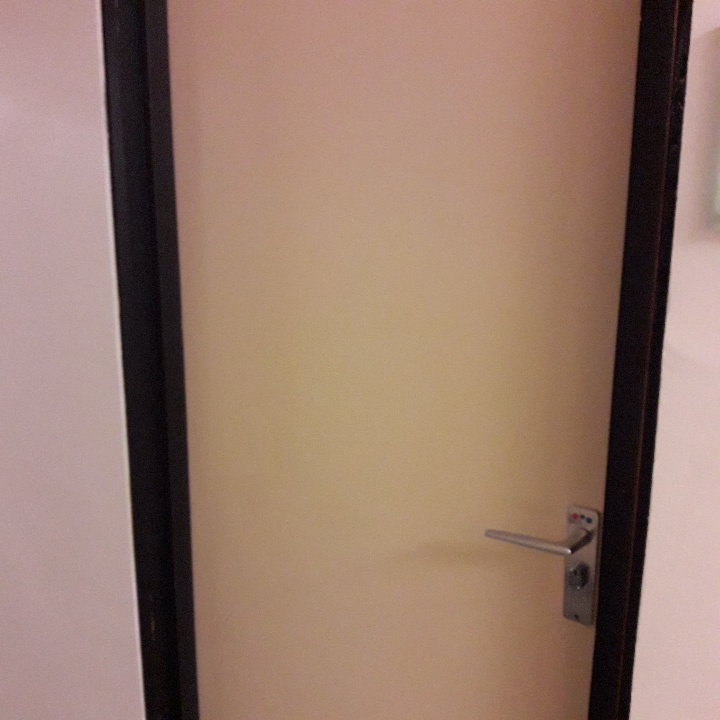

In [26]:
img1

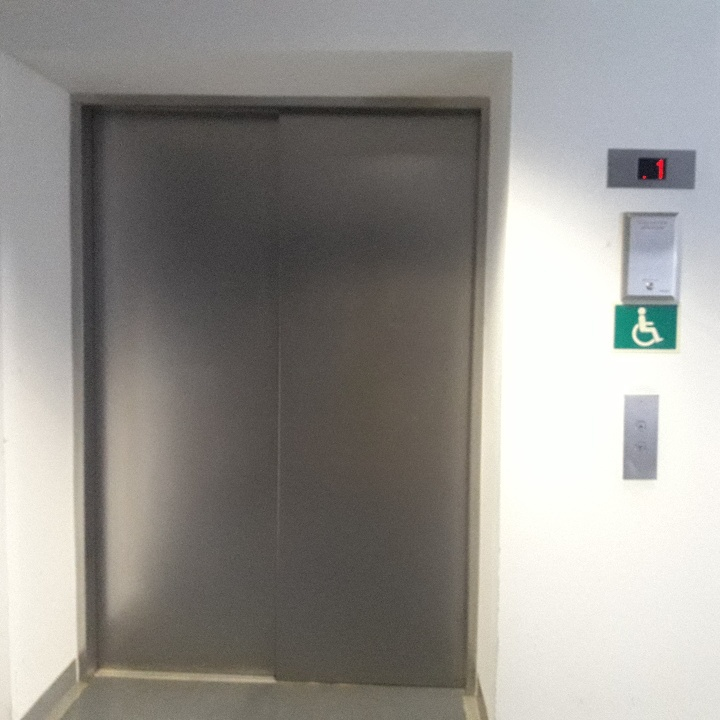

In [27]:
img2

In [124]:
np.array(img)[:].shape

(720, 720, 3)

In [68]:
mm.get_embedding(img)

1 3 322 322


[0.01048955600708723,
 -0.0001390117104165256,
 0.004422792699187994,
 -0.010308979079127312,
 -0.007217354141175747,
 0.011199602857232094,
 0.005625489633530378,
 0.002636023797094822,
 -0.014232178218662739,
 0.00867029745131731,
 -0.0008655738201923668,
 0.008717558346688747,
 -0.005730664357542992,
 0.0006362175336107612,
 -0.011621627025306225,
 0.004489869344979525,
 -0.0016098960768431425,
 0.017981065437197685,
 -0.019728470593690872,
 -0.005368588492274284,
 0.00964752584695816,
 0.012458525598049164,
 -0.0015374672366306186,
 -0.0015716284979134798,
 0.00027731191948987544,
 -0.008864580653607845,
 -0.0009606500389054418,
 -0.00938370916992426,
 0.003047260222956538,
 -6.383251457009465e-05,
 0.0110287731513381,
 -0.0076200650073587894,
 0.008464205078780651,
 0.017863666638731956,
 0.022275632247328758,
 -0.01327710784971714,
 0.010109919123351574,
 0.022943247109651566,
 0.001215076306834817,
 0.007879610173404217,
 -0.012012756429612637,
 0.011657032184302807,
 0.00056044

In [69]:
pp = mm.get_embeddings([img1,img2])

Calculating descritptors...:   0%|          | 0/2 [00:00<?, ?it/s]

1 3 322 322
1 3 322 322


In [74]:
type(pp[0][0])

float